<a href="https://colab.research.google.com/github/yashjhota/mental-health-text-classification/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📂 Data Load & Preprocessing 🧹

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_json("/content/drive/MyDrive/WORLD-LARGEST-DATASET-MENTAL/mental_health_dataset-part-1.json", lines=True)

In [4]:
df.sample(10)

,id,subreddit,text,label,created_utc
29,1lt8h10,depression,Can depression lead to masochism? I'm not refe...,1,2025-07-06T18:35:32
2007,1ls0ygp,Anxiety,Hallucinations? Hey... I didn't really want to...,1,2025-07-05T03:57:31
3729,1lho0n2,DecidingToBeBetter,How to know what area of your life to start wo...,0,2025-06-22T13:34:35
341,1lsuowu,depression,Confused. Don’t know why I am coming to this s...,1,2025-07-06T06:40:03
945,1ltjauj,SuicideWatch,For how long i need to suffocate in order to d...,1,2025-07-07T02:54:03
3200,1ltt2ec,DecidingToBeBetter,Who/what do you live for? People submit their ...,0,2025-07-07T12:38:00
1252,1lsacnm,SuicideWatch,sometimes being suicidal just feels liberating...,1,2025-07-05T13:50:55
3754,1lgjjad,DecidingToBeBetter,I always feel bad when I stand up for myself o...,0,2025-06-21T00:29:40
285,1lt30k2,depression,A house is not always a home... I just want to...,1,2025-07-06T14:48:16
1752,1lt5fr4,Anxiety,How do you deal with fear? How do you cope wi...,1,2025-07-06T16:29:50


In [6]:
df.shape

(3867, 5)

In [10]:
df['subreddit'].value_counts()

,count
subreddit,
Anxiety,948
SuicideWatch,838
depression,738
DecidingToBeBetter,670
Happy,491
GetMotivated,182


In [12]:
df['label'].value_counts()

,count
label,
1,2524
0,1343


In [13]:
df.drop(columns=["id","created_utc","subreddit"],inplace=True)

In [14]:
df.head()

,text,label
0,august 26 will be my last day. just wanted som...,1
1,I wish I was dead I wish I never woke up tomor...,1
2,Yea life wasn’t meant for me It just wasn’t. I...,1
3,I’m tired of being here tbh I’m so tired of be...,1
4,"Just want it to stop M 22, I have no desire no...",1


# 🧠 Simple RNN ⏳

## 🔤 Tokenizer & 🔧 Padding

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
tk = Tokenizer()
tk.fit_on_texts(df['text'])

In [19]:
len(tk.word_index)

21043

In [45]:
sequences = tk.texts_to_sequences(df['text'])

In [22]:
from keras.utils import pad_sequences
sequences = pad_sequences(sequences,padding='post')
sequences

array([[ 2653,  1398,    74, ...,     0,     0,     0],
       [    1,   282,     1, ...,     0,     0,     0],
       [ 4944,    36,   462, ...,     0,     0,     0],
       ...,
       [    1,   119,    81, ...,     0,     0,     0],
       [  190,     7,     4, ...,     0,     0,     0],
       [  324, 21041,    33, ...,     0,     0,     0]], dtype=int32)

In [24]:
len(sequences[0])

2784

## 🏗️ Architecture – **Simple RNN**  🎯 Only **3 hidden units**

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

vocab_size = 21044
embedding_dim = 100
sequence_length = 2784

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=sequence_length))
model.add(SimpleRNN(3))
model.add(Dense(1, activation='sigmoid'))

# Explicitly build with full input shape: (batch_size, timesteps)
model.build(input_shape=(None, sequence_length))

# Now you will see the parameters
model.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 2784, 100)      │     2,104,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 3)              │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,104,716 (8.03 MB)

 Trainable params: 2,104,716 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

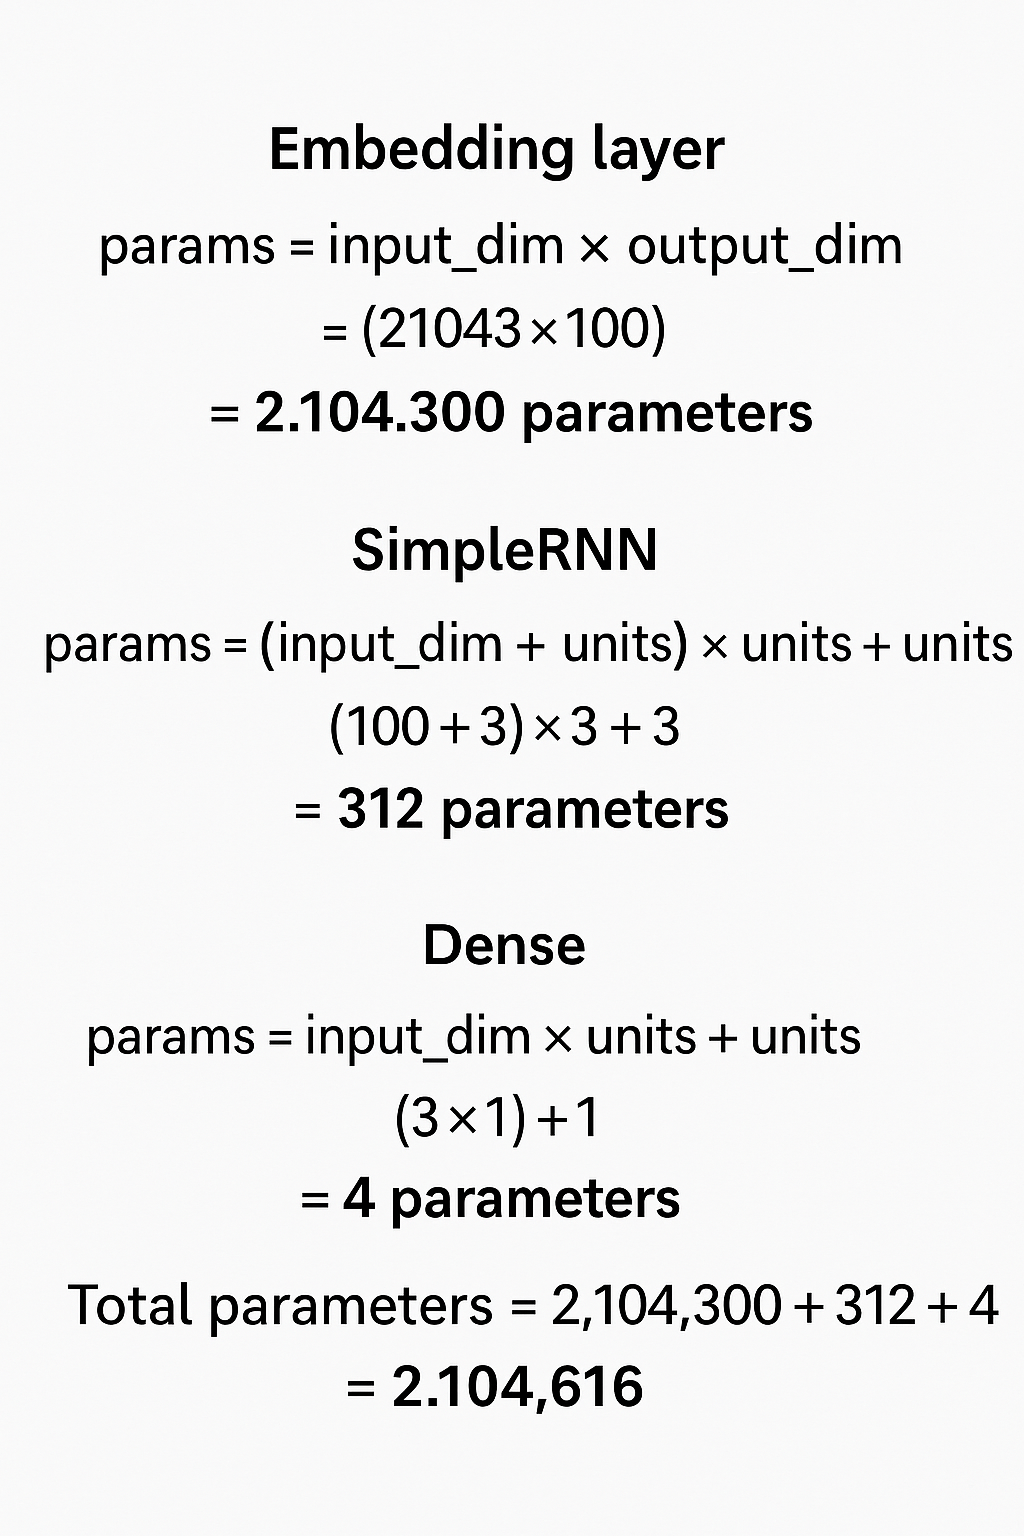

In [59]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(sequences,df['label'],test_size=0.2)

In [60]:
X_train = pad_sequences(X_train,padding='post')
X_test = pad_sequences(X_test,padding='post')

In [61]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - acc: 0.6615 - loss: 0.6397 - val_acc: 0.6473 - val_loss: 0.6492
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - acc: 0.6618 - loss: 0.6409 - val_acc: 0.6473 - val_loss: 0.6492
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - acc: 0.6589 - loss: 0.6420 - val_acc: 0.6473 - val_loss: 0.6493
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - acc: 0.6221 - loss: 0.6645 - val_acc: 0.6473 - val_loss: 0.6520
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - acc: 0.6438 - loss: 0.6531 - val_acc: 0.6473 - val_loss: 0.6495


## 🐌 It’s moving **slowly**, that’s because:  

1. 📏 **Sequence length is huge**: 2 784 timesteps  

2. 📚 **Vocabulary size is huge**: 21 K words  
3. ⏳ **RNNs process timesteps sequentially** (no parallelization like Transformers)  

---

## ⚡ We can make it **much faster** by:  

1. ✂️ **Reduce `sequence_length`** – truncate / pad to something shorter  
2. 🧠 **Switch to a smaller GRU / LSTM** (or even better → a **1-D CNN** or **Transformer** for long sequences)  
3. 📉 **Shrink `embedding_dim`** to something < 100  
4. 🚀 **Move to GPU** if you’re still on CPU  

# 🤔 What is **97**?

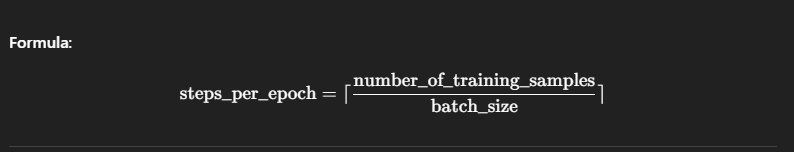


In [65]:
#Example training size
len(X_train) / 32
# Batch size by default is 32

96.65625

## 🔁 What happens inside **one epoch**?

- 📦 Each **training step** the model sees **32 sentences** (= the batch size).  
- 📊 Therefore:  
  `Steps per epoch = 97`  
  `97 × 32 = 3 104 sentences`  
  (exactly your full training set size)

---

## ⏱️ **Timeline of a single epoch**

1. ⏩ **Step 1**: first 32 sentences → forward pass → back-prop → weights update  
2. ⏩ **Step 2**: next 32 sentences → forward/back-prop → update again  
3. …  
97. 🏁 **Step 97**: last batch (might be ≤ 32 sentences) → final update → epoch done!

## 🔄 One step at a time  
🚀 **Each step** = process **32 sentences** → compute loss → backpropagate → **update weights once**  

📊 **97 steps / epoch** → **97 weight updates / epoch**

---

## 📈 Five-epoch math  
`97 × 5 = 485` **total weight updates** 💡

---

## 🎬 Training flow in emoji  

- 🎲 **Start**: random (or initialized) weights  
- 🏃‍♂️ **Step 1**: 32 sentences → loss → backprop → **update #1**  
- 🏃‍♂️ **Step 2**: next 32 sentences → loss → backprop → **update #2**  
- …  
- 🏁 **Step 97**: last 32 sentences → **update #97** → **epoch 1 complete**  
- 🔄 **Next epoch**: repeat dataset again (epochs 2 → 5)

# ⚫ Simple RNN – Prediction Time 🔮

In [66]:
# Example: X_test is padded/tokenized test data
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step


In [69]:
y_pred_probs[10:15]

array([[0.6592322],
       [0.6592322],
       [0.6592322],
       [0.6592322],
       [0.6592322]], dtype=float32)

In [70]:
y_test[10:15]

,label
3739,0
2733,0
2152,1
1623,1
2630,0


In [77]:
sentence = "Sometimes it feels like I’m walking through a heavy fog of depression that never lifts, where each step takes more strength than I have, and even though people are around me, I feel completely alone, as if my voice doesn’t matter, my presence goes unnoticed, and my thoughts sometimes drift toward suicide or wondering if it would be easier to kill the pain entirely, yet a small part of me keeps whispering that maybe, just maybe, someone will notice, someone will listen, and I hold onto that faint hope, because if there’s even a single chance for light to return, my story isn’t over yet."
seq = tk.texts_to_sequences([sentence])
padded = pad_sequences(seq, maxlen=2784)  # use same maxlen as training
prob = model.predict(padded)[0][0]
label = int(prob > 0.6)

print("Probability:", prob)
print("Predicted label:")
if label == 1:
    print("Positive")
else:
    print("Negative")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Probability: 0.5471808
Predicted label:
Negative


# 🏗️ Slightly Smarter Architecture – LSTM 🧠✨

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

## 1️⃣ ✂️ Reduce Sequence Length  
**Action**: Truncate / pad to **200–500 tokens** with `pad_sequences(maxlen=…)`.  
💡 Most NLP tasks don’t need thousands of tokens—long sequences just **slow training to a crawl**.

In [79]:
from keras.utils import pad_sequences
sequences = pad_sequences(sequences,padding='post',maxlen=300)
sequences

array([[ 2653,  1398,    74, ...,     0,     0,     0],
       [    1,   282,     1, ...,     0,     0,     0],
       [ 4944,    36,   462, ...,     0,     0,     0],
       ...,
       [    1,   119,    81, ...,     0,     0,     0],
       [  190,     7,     4, ...,     0,     0,     0],
       [  324, 21041,    33, ...,     0,     0,     0]], dtype=int32)

In [80]:
len(sequences[0])

300

## 2️⃣ 🚀 Boost LSTM Capacity  
- 🔧 **Units**: bump up to **64** or **128**  
- 🥞 **Stack**: add a second LSTM layer (`return_sequences=True` on the first) for deeper modeling

In [81]:
vocab_size = 21044
embedding_dim = 100
sequence_length = 300

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=sequence_length))


model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, sequence_length))


model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 300, 100)       │     2,104,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 300, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,159,089 (8.24 MB)

 Trainable params: 2,159,089 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
X_train = pad_sequences(X_train,padding='post',maxlen=300)
X_test = pad_sequences(X_test,padding='post',maxlen=300)

In [83]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [84]:
history = model.fit(X_train, y_train,epochs=10,validation_data=(X_test,y_test))

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 493ms/step - acc: 0.6497 - loss: 0.6462 - val_acc: 0.6473 - val_loss: 0.6558
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 74s 407ms/step - acc: 0.6653 - loss: 0.6440 - val_acc: 0.6473 - val_loss: 0.6543
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 383ms/step - acc: 0.6387 - loss: 0.6548 - val_acc: 0.6473 - val_loss: 0.6539
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 34s 349ms/step - acc: 0.6467 - loss: 0.6521 - val_acc: 0.6473 - val_loss: 0.6495
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 430ms/step - acc: 0.6575 - loss: 0.6445 - val_acc: 0.6473 - val_loss: 0.6497
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 84s 453ms/step - acc: 0.6639 - loss: 0.6389 - val_acc: 0.6473 - val_loss: 0.6496
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 34s 354ms/step - acc: 0.6558 - loss: 0.6447 - val_acc: 0.6473 - val_loss: 0.6494
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 391ms/step - acc: 0.6582 - loss: 0.6427 - val_acc: 0.6473 - val_loss: 0.6509
Epoch 9/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 341ms/

In [85]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)

## 3️⃣ ↔️ Bidirectional LSTM + 🌧️ Dropouts

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

vocab_size = 21044
embedding_dim = 100
sequence_length = 300

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, sequence_length))
model.summary()


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 300, 100)       │     2,104,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189,009 (8.35 MB)

 Trainable params: 2,189,009 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [92]:
# import callbacks
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

In [ ]:
history = model.fit(X_train, y_train,epochs=10,validation_data=(X_test,y_test),batch_size=16,callbacks=callbacks)

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 200s 981ms/step - accuracy: 0.6517 - loss: 0.6527 - val_accuracy: 0.6473 - val_loss: 0.6524
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 160s 766ms/step - accuracy: 0.6532 - loss: 0.6524 - val_accuracy: 0.6473 - val_loss: 0.6500
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 199s 753ms/step - accuracy: 0.6461 - loss: 0.6541 - val_accuracy: 0.6473 - val_loss: 0.6495
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 148s 761ms/step - accuracy: 0.6361 - loss: 0.6581 - val_accuracy: 0.6473 - val_loss: 0.6495
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 200s 753ms/step - accuracy: 0.6634 - loss: 0.6432 - val_accuracy: 0.6473 - val_loss: 0.6573
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 202s 754ms/step - accuracy: 0.6505 - loss: 0.6523 - val_accuracy: 0.6473 - val_loss: 0.6552
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 202s 755ms/step - accuracy: 0.6613 - loss: 0.6445 - val_accuracy: 0.6473 - val_loss: 0.6496
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 159s 819ms/step - accuracy: 0.6408 -

In [ ]:
plot_graphs(history, 'accuracy')

## 4️⃣ ⬅️ Swapped LSTM → GRU

In [ ]:
from tensorflow.keras.layers import GRU

vocab_size = 21044
embedding_dim = 100
sequence_length = 300

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=sequence_length))


model.add(GRU(64, return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, sequence_length))


model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,epochs=10,validation_data=(X_test,y_test))